### Imports and Set Up

In [1]:
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score 
import numpy as np
import pandas as pd
import time
import modelMLP 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
sc.settings.verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

### Prepping Data

##### expression profile

In [3]:
adata =  sc.read_h5ad("data/Norman_2019.h5ad")  # replace with your path

#export data from sc.read
ddata = adata.X.toarray()
labels = adata.obs['perturbation_name'].to_numpy()
parsed_labels = [p.split('+') if p != 'control' else [] for p in labels]
mlb = MultiLabelBinarizer()
labels_int = mlb.fit_transform(parsed_labels)

##### creating positional encoding

In [4]:
import pyensembl
from tqdm import tqdm

data = pyensembl.EnsemblRelease(109)
data.download()
data.index()

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle


In [5]:
chromosome_lengths = {
    #from https://www.ncbi.nlm.nih.gov/grc/human/data
    # Autosomes
    '1': 231223641,
    '2': 240863511,
    '3': 198255541,
    '4': 189962376,
    '5': 181358067,
    '6': 170078524,
    '7': 158970135,
    '8': 144768136,
    '9': 122084564,
    '10': 133263006,
    '11': 134634058,
    '12': 133137821,
    '13': 97983128,
    '14': 91660769,
    '15': 85089576,
    '16': 83378703,
    '17': 83481871,
    '18': 80089650,
    '19': 58440758,
    '20': 63944268,
    '21': 40088623,
    '22': 40181019,
    # Sex Chromosomes
    'X': 154893034,
    'Y': 26452288
}

chr_names = [str(i) for i in range(1, 23)] + ['X', 'Y']
chromosome_map = {name: i for i, name in enumerate(chr_names)}

In [6]:
gene_to_pos_encoding = {}
zero_encoding = np.zeros(24)

for gene_name in tqdm(adata.var_names):
    try:
        gene = data.genes_by_name(gene_name)
        encoding = np.zeros(24)
        contig = gene[0].contig
        if pd.notna(contig) and contig in chromosome_map:
            chr_index = chromosome_map[contig]
            chr_length = chromosome_lengths.get(contig, 0)
            if chr_length > 0:
                encoding[chr_index] = gene[0].start / chr_length
        gene_to_pos_encoding[gene_name] = encoding
    except (ValueError, KeyError):
        continue 



final_positional_encoding = []

for perturbation_string in tqdm(adata.obs['perturbation_name']):
    if perturbation_string == 'control':
        final_positional_encoding.append(zero_encoding)
        continue

    gene_names_in_pert = perturbation_string.split('+')
    
    encodings_for_this_cell = []
    for gene_name in gene_names_in_pert:
        encoding = gene_to_pos_encoding.get(gene_name, zero_encoding)
        encodings_for_this_cell.append(encoding)

    averaged_encoding = np.mean(encodings_for_this_cell, axis=0)
    final_positional_encoding.append(averaged_encoding)

final_positional_encoding = np.array(final_positional_encoding)

print(f"\nSUCCESS: Final matrix generated with shape {final_positional_encoding.shape}")

100%|██████████| 111255/111255 [00:00<00:00, 298549.27it/s]


SUCCESS: Final matrix generated with shape (111255, 24)


##### New step

In [7]:
mlb = MultiLabelBinarizer()
# Fit on all possible labels to ensure consistency
all_possible_genes = list(set([item for sublist in parsed_labels for item in sublist]))
mlb.fit([all_possible_genes])

,classes,None
,sparse_output,False


In [8]:
adata.obsm['X_pca'].shape

(111255, 50)

--- Step 1: Preparing graph data ---
Node features created with shape: torch.Size([111255, 50])
Graph structure created with 2668042 edges.
Constructing edge features by merging positional, distance, and connectivity data...
Edge features created with shape: torch.Size([2668042, 50])
Graph data preparation complete.

--- Starting GAT model training with live plotting ---


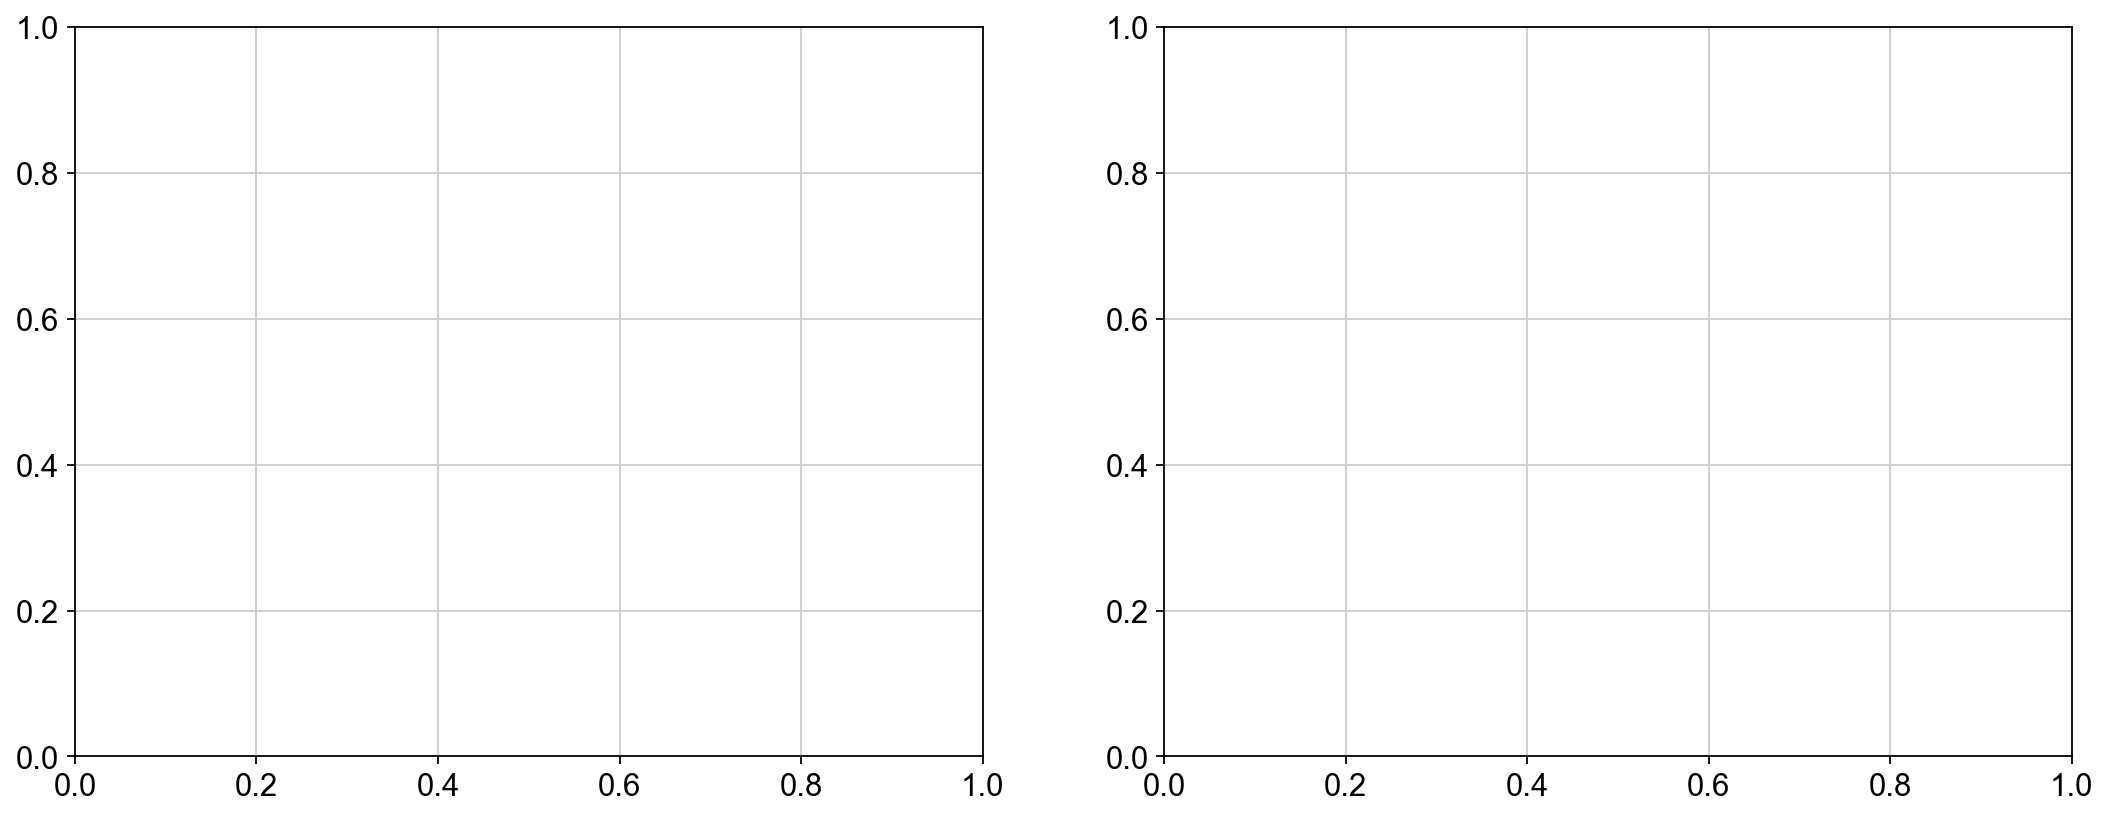

In [ ]:
import modelPairwise
graph_data = modelPairwise.prepare_graph_data(adata, mlb, final_positional_encoding, parsed_labels)

model = modelPairwise.EdgeConditionedGAT(
        in_channels=graph_data.num_node_features,
        edge_dim=graph_data.num_edge_features,
        hidden_channels=32,
        out_channels=len(mlb.classes_), # Use length of fitted classes
        heads=8
    )

    # 3. Set up optimizer and loss, then run training
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.BCEWithLogitsLoss()
    
modelPairwise.run_training_with_plotting(graph_data, model, optimizer, criterion)
